## Meyer 2021 data processing.

This data was updated and so we need to re-process it.

__author__ = "Ciro Ramírez-Suástegui"

__copyright__ = "Copyright 2022-07-07, Helmholtz Zentrum Muenchen"

__license__ = "GPL"

__version__ = "0.0.9"

__maintainer__ = "Ciro Ramírez-Suástegui"

__email__ = "ciro.suastegui@helmholtz-muenchen.de, ksuasteguic@gmail.com"

__status__ = "Prototype"

#### Structure

* [Load data](#bullet1)
* [Raw counts in adata.X](#bullet2)
* [Metadata harmonization](#bullet3)
* [Quality Control](#bullet4)
* [Remove doublets](#bullet5)
* [Make object lightweight](#bullet6)
* [Check if you need to split them into datasets](#bullet7)
* [Write down everything you did in the "preprocessing" column](#bullet8)
* [Subset to HVGs](#bullet8)
* [Store the data](#bullet10)
* [Update the stats for your dataset](#bullet11)

### Environment setup

In [1]:
%load_ext autoreload
%autoreload 2
import importlib

spam_spec = importlib.util.find_spec("lab_black")
if spam_spec is not None:
    %load_ext lab_black
else:
    print("No pretty code for us today")

No pretty code for us today


In [2]:
# basic modules
import os, re, time
import sys, warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [3]:
# in-house/developing modules
sys.path.append("../../../scripts/")
import preprocessing as pp

# tools modules
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sc.logging.print_versions()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.8
scanpy      1.8.2
sinfo       0.3.4
-----
PIL                         9.0.0
autoreload                  NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
cached_property             1.5.2
cffi                        1.15.0
colorama                    0.4.4
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml       

In [4]:
# setting visualisation parameters
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(10, 10))

In [5]:
print("Environment:", re.sub(".os.py", "", os.__file__))
parentpath = lambda _path, n: os.sep.join(_path.split(os.sep)[:-n])
print("Working at:", re.sub(parentpath(os.getcwd(), 2), "", os.getcwd()))

Environment: /home/icb/ciro.suastegui/miniconda3/envs/scarches_0_3_5/lib/python3.7
Working at: /3_atlas_extension/HLCA_extension_data_preprocessing


### Global variables and paths

In [6]:
adata_inp = "../../../data/HLCA_extended/extension_datasets/raw/Meyer/Meyer_2021_raw.h5ad"
adata_dir_out = "../../../data/HLCA_extended/extension_datasets/ready"
mdata_donor_inp = (
    "../../../data/HLCA_extended/extension_datasets/metadata/Meyer_2021.xlsx"
)
genes_set_inp = "../../../notebooks/3_atlas_extension/HLCA_extension_data_preprocessing/genes_for_mapping.csv"

### Load data <a class="anchor" id="bullet1"></a>

In [7]:
adata = sc.read_h5ad(adata_inp)
adata_obs = adata.obs

In [8]:
adata

AnnData object with n_obs × n_vars = 129340 × 20922
    obs: 'Celltypes', 'Celltypes_master_high', 'Celltypes_master_higher', 'Celltypes_master_higher_immune', 'Celltypes_master_2', 'Celltypes_master_3', 'Loc_true', 'Material', 'scsn', 'Donor', 'Donor_ID_2', 'Gender', 'Sample', 'ID', 'Protocol_plot', 'Version', 'Study', 'PoolDon', 'DonorPool', 'scDonor_snBatch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'gene_ids-0', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'gene_ids-1', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'feature_types-1', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'Celltypes_colors', 'Celltypes_master_high_colors', 'ID_colors', 'Loc_true_colors', 'Material_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'p

### Raw counts in adata.X <a class="anchor" id="bullet2"></a>

In [9]:
print(adata.layers, len(adata.layers))
print("Is adata.raw present?", adata.raw is not None)

Layers with keys:  0
Is adata.raw present? False


In [10]:
adata.X[:10, :10].A

array([[0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 1.5463033, 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 2.2631125],
       [0.       , 0.       , 0.       , 0.       , 2.077501 , 0.       ,
        0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.     

In [11]:
pd.Series(adata.X[:100, :100].A.flatten()).value_counts().head(10)

0.000000    9599
0.861869       3
2.141924       2
1.831350       2
1.360282       2
2.495206       2
1.467120       2
0.680044       2
1.331458       2
0.684905       2
dtype: int64

We were told this is soupX data. So, we will treat it as raw counts.

### Metadata harmonization <a class="anchor" id="bullet3"></a>

In [12]:
for i in list(set(adata_obs.columns) - set(adata_obs._get_numeric_data().columns)):
    print("=========", i)
    adata_obs[i] = adata_obs[i].astype("category")
    print(adata_obs[i].value_counts())

========= Celltypes_master_3
Immune       70599
Epithelia    22635
Vascular     21640
Stroma       14466
Name: Celltypes_master_3, dtype: int64
========= Sample
WSSS8062679          10941
WSSS8015045           8981
WSSS8015046           8288
WSSS8062680           5997
WSSS8062682           5323
WSSS8062681           4743
WSSS8015044           4126
WSSS8123931           3656
WTDAtest7732269       3425
HCATisStab7732262     3322
WSSS8123926           3246
WTDAtest7732270       3126
WSSS8123927           2925
WTDAtest7732265       2874
WSSS_A_LNG8620063     2792
5841STDY7991475       2578
WSSS8015049           2568
WSSS_A_LNG8620059     2323
HCATisStab7732264     2304
WSSS_A_LNG8620062     2296
WTDAtest7732268       2238
WSSS8015048           2171
WSSS8123930           2120
WSSS8015047           2050
HCATisStab7732263     1981
5841STDY7991482       1973
WTDAtest7732267       1937
5841STDY7991483       1854
WSSS8015042           1829
WTDAtest7732266       1789
5841STDY7991479       1528
58

#### Extra sample metadata

Get it from the online [metadata](https://docs.google.com/spreadsheets/d/1J1lhBvwR-ofc8ItgEizOEvjFSA-txCxF-3lgz9--6EA).

We simply used `wget.download`

First, the sample "aggr_30328_5841STDY7991475_and_32400_WSSS_A_LNG8708934" is called "5841STDY7991475." So, we changed it's name in the metadata we are loading.

In [13]:
sample_column = "Sample"
adata_obs.loc[adata_obs[sample_column].isin(["5841STDY7991475"]), :]

,Celltypes,Celltypes_master_high,Celltypes_master_higher,Celltypes_master_higher_immune,Celltypes_master_2,Celltypes_master_3,Loc_true,Material,scsn,Donor,...,Version,Study,PoolDon,DonorPool,scDonor_snBatch,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACCTGAGACTAGGC-5841STDY7991475-0,Macro_int,Myeloid,Immune,Macrophage_other,Immune,Immune,d_LowLeftPar,cells,cells,A37,...,10x5prime,5_loc,nan,nan,A37_cells,2232,2232,6555.885254,787.818420,12.016965
AAACCTGAGAGTACAT-5841STDY7991475-0,Macro_int,Myeloid,Immune,Macrophage_other,Immune,Immune,d_LowLeftPar,cells,cells,A37,...,10x5prime,5_loc,nan,nan,A37_cells,2668,2668,8248.313477,610.853149,7.405795
AAACCTGAGCTACCTA-5841STDY7991475-0,NK_CD16hi,T_NK,Immune,NK,Immune,Immune,d_LowLeftPar,cells,cells,A37,...,10x5prime,5_loc,nan,nan,A37_cells,1882,1882,4262.053223,193.328659,4.536046
AAACCTGCAGGACCCT-5841STDY7991475-0,NK_CD16hi,T_NK,Immune,NK,Immune,Immune,d_LowLeftPar,cells,cells,A37,...,10x5prime,5_loc,nan,nan,A37_cells,1694,1694,3953.793945,201.248001,5.089997
AAACCTGCAGTGAGTG-5841STDY7991475-0,Endothelia_Lymphatic,Endothelia_lymphatic,Stroma,Endothelia_lymphatic,Stroma,Vascular,d_LowLeftPar,cells,cells,A37,...,10x5prime,5_loc,nan,nan,A37_cells,3873,3873,16363.325195,555.654419,3.395731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCACACGACGAA-5841STDY7991475-0,Monocyte_CD14,Myeloid,Immune,Monocyte,Immune,Immune,d_LowLeftPar,cells,cells,A37,...,10x5prime,5_loc,nan,nan,A37_cells,1131,1131,3029.662598,192.913544,6.367493
TTTGTCACAGCTTCGG-5841STDY7991475-0,CD4_TRM,T_NK,Immune,CD4,Immune,Immune,d_LowLeftPar,cells,cells,A37,...,10x5prime,5_loc,nan,nan,A37_cells,1191,1191,2105.397705,156.635834,7.439727
TTTGTCAGTCGAGTTT-5841STDY7991475-0,Macro_CHIT1,Myeloid,Immune,Macrophage_other,Immune,Immune,d_LowLeftPar,cells,cells,A37,...,10x5prime,5_loc,nan,nan,A37_cells,1717,1717,4607.916504,330.048187,7.162633
TTTGTCATCGCACTCT-5841STDY7991475-0,Macro_alv,Myeloid,Immune,Macrophage_alveolar,Immune,Immune,d_LowLeftPar,cells,cells,A37,...,10x5prime,5_loc,nan,nan,A37_cells,4207,4207,23241.357422,850.564209,3.659701


In [14]:
mdata_index = "library_ID"
mdata_donor = pd.read_excel(
    mdata_donor_inp, engine="openpyxl", header=0, index_col=mdata_index
)
mdata_donor = mdata_donor.iloc[
    3:,
]
mdata_donor[mdata_index] = mdata_donor.index.tolist()
mdata, mdata_donor_lost = pp.metadata_match(adata_obs, sample_column, mdata_donor)

Number of samples in metadata: 60
Number of samples in anndata: 59
(59, 36)
Missing columns:
 publication_ID
 repository_ID
 age_range
 ethnicity_2
 ethnicity_free_text
 disease_condition
 anatomical_region_level2
 library_construction_batch
 sample_collection_relative_timepoint
(129340, 36)
Checking Difference between final and donor/sample medadata.


In [15]:
mdata_donor_lost

,institute,study_PI,sample_ID,subject_ID,publication_ID,repository_ID,subject_ID_published,subject_developmental_state,age_years,age_range,...,sample_collection_year,sample_collection_relative_timepoint,disease_status,treatment_status,sample_status,sample_cultured,cell_number_loaded,cell_viability_percentage,comments,library_ID
library_ID,,,,,,,,,,,,,,,,,,,,,
WSSS_A_LNG8708934,Sanger Institute,Kerstin Meyer,A37-LNG-1-SC-45P-1,428C,NaN,NaN,A37,postnatal,59.0,NaN,...,2020,NaN,healthy (organ donor),prev paracetamol overdose (3 years prior to ci...,fresh,no,10000,74,NaN,WSSS_A_LNG8708934


It looks like the annotated data is missing WSSS_A_LNG8708934. In the past this was an "[unannotated](https://github.com/LungCellAtlas/HLCA_reproducibility/blob/eba76b718d291baf573b0c028605aeb411098bf5/scripts/LCA_file_reading.py)" sample.

#### Setting metadata

In [16]:
# MANDATORY # &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
mdata["study"] = "Meyer_2021"  # [Last_author]_[year]
# if no splitting into different datasets, use 'study'
mdata["dataset"] = [
    f"{study}_{prime[0]}prime"
    for study, prime in zip(mdata.study, mdata.strand_sequence)
]
mdata["sample"] = adata_obs[sample_column]
mdata["subject_ID"] = mdata["subject_ID_published"]
mdata["disease_condition"] = "Healthy"
mdata["original_celltype_ann"] = adata_obs.Celltypes
# OPTIONAL # &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
# mdata["sex"]
# mdata["age"]
# mdata["ethnicity"]
# mdata["bmi"]
# mdata["smoking_status"]
# FELL FREE TO ADD MORE? # &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
# mdata["disease_status"]
mdata

,institute,study_PI,sample_ID,subject_ID,library_ID,subject_ID_published,subject_developmental_state,age_years,sex,ethnicity_1,...,sample_status,sample_cultured,cell_number_loaded,cell_viability_percentage,comments,study,dataset,sample,disease_condition,original_celltype_ann
AAACCTGGTGTGAATA-1-WTDAtest7887999-0,Sanger Institute,Kerstin Meyer,A32-LNG-1-SC-45N-1,A32,WTDAtest7887999,A32,postnatal,29.0,male,white,...,fresh,no,5000,93,NaN,Meyer_2021,Meyer_2021_3prime,WTDAtest7887999,Healthy,AT1
AAACGGGCAACCGCCA-1-WTDAtest7887999-0,Sanger Institute,Kerstin Meyer,A32-LNG-1-SC-45N-1,A32,WTDAtest7887999,A32,postnatal,29.0,male,white,...,fresh,no,5000,93,NaN,Meyer_2021,Meyer_2021_3prime,WTDAtest7887999,Healthy,B_plasma
AACCATGGTACAGCAG-1-WTDAtest7887999-0,Sanger Institute,Kerstin Meyer,A32-LNG-1-SC-45N-1,A32,WTDAtest7887999,A32,postnatal,29.0,male,white,...,fresh,no,5000,93,NaN,Meyer_2021,Meyer_2021_3prime,WTDAtest7887999,Healthy,Monocyte_CD16
AACGTTGGTGTCCTCT-1-WTDAtest7887999-0,Sanger Institute,Kerstin Meyer,A32-LNG-1-SC-45N-1,A32,WTDAtest7887999,A32,postnatal,29.0,male,white,...,fresh,no,5000,93,NaN,Meyer_2021,Meyer_2021_3prime,WTDAtest7887999,Healthy,CD8_EM/EMRA
AACTCCCTCCTAGTGA-1-WTDAtest7887999-0,Sanger Institute,Kerstin Meyer,A32-LNG-1-SC-45N-1,A32,WTDAtest7887999,A32,postnatal,29.0,male,white,...,fresh,no,5000,93,NaN,Meyer_2021,Meyer_2021_3prime,WTDAtest7887999,Healthy,Macro_int
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCACAATGACCT-WSSS8123931-0,Sanger Institute,Kerstin Meyer,A44-LNG-5-SC-45N-1,A44,WSSS8123931,A44,postnatal,66.0,male,white,...,fresh,no,10000,89,NaN,Meyer_2021,Meyer_2021_5prime,WSSS8123931,Healthy,Endothelia_vascular_Cap_g
TTTGTCAGTCCGTCAG-WSSS8123931-0,Sanger Institute,Kerstin Meyer,A44-LNG-5-SC-45N-1,A44,WSSS8123931,A44,postnatal,66.0,male,white,...,fresh,no,10000,89,NaN,Meyer_2021,Meyer_2021_5prime,WSSS8123931,Healthy,Endothelia_vascular_Cap_g
TTTGTCAGTTGCGCAC-WSSS8123931-0,Sanger Institute,Kerstin Meyer,A44-LNG-5-SC-45N-1,A44,WSSS8123931,A44,postnatal,66.0,male,white,...,fresh,no,10000,89,NaN,Meyer_2021,Meyer_2021_5prime,WSSS8123931,Healthy,NK_CD16hi
TTTGTCATCAGTTCGA-WSSS8123931-0,Sanger Institute,Kerstin Meyer,A44-LNG-5-SC-45N-1,A44,WSSS8123931,A44,postnatal,66.0,male,white,...,fresh,no,10000,89,NaN,Meyer_2021,Meyer_2021_5prime,WSSS8123931,Healthy,Endothelia_vascular_Cap_g


#### Copy cell types to the cell type mapping [sheet](https://docs.google.com/spreadsheets/d/1I6NXTZBZqPpq6l3qG5mqdxaWVnovm9F9NAvUuoyXWJw/edit#gid=0).

In [17]:
df = pd.crosstab(mdata.original_celltype_ann, mdata["anatomical_region_level1"])
df = df.loc[sorted(df.index.values.astype(str))]
df = df.div(df.sum(axis=0), axis=1)
df["original_celltype_ann"] = df.index.values
df = df.set_index("original_celltype_ann")
df = df.div(df.sum(axis=1), axis=0).round(3)
pd.set_option("display.max_rows", df.shape[0])
df[df.select_dtypes(include=["number"]).columns] * 100

anatomical_region_level1,airway,parenchyma
original_celltype_ann,,
AT1,19.5,80.5
AT2,22.1,77.9
B_mature,57.7,42.3
B_naive,58.5,41.5
B_plasma,56.5,43.5
B_plasmablast,42.1,57.9
Basal,95.6,4.4
CD4_EM/Effector,37.2,62.8
CD4_TRM,36.7,63.3


In [18]:
adata.obs = mdata
adata

AnnData object with n_obs × n_vars = 129340 × 20922
    obs: 'institute', 'study_PI', 'sample_ID', 'subject_ID', 'library_ID', 'subject_ID_published', 'subject_developmental_state', 'age_years', 'sex', 'ethnicity_1', 'smoking_status', 'smoking_history', 'bmi', 'disease_lung_known', 'subject_type', 'cause_of_death', 'sample_type', 'anatomical_region_level1', 'anatomical_region_level3', 'protocol_tissue_dissociation', 'biological_unit', 'library_platform', 'strand_sequence', 'cell_enrichment', 'sequencing_platform', 'reference_genome', 'reference_genome_ensembl_release', 'reads_processing', 'sample_collection_year', 'disease_status', 'treatment_status', 'sample_status', 'sample_cultured', 'cell_number_loaded', 'cell_viability_percentage', 'comments', 'study', 'dataset', 'sample', 'disease_condition', 'original_celltype_ann'
    var: 'mt', 'gene_ids-0', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'gene_ids-1', 'n_cells-1', 'n_cells_by_

### Quality Control <a class="anchor" id="bullet4"></a>

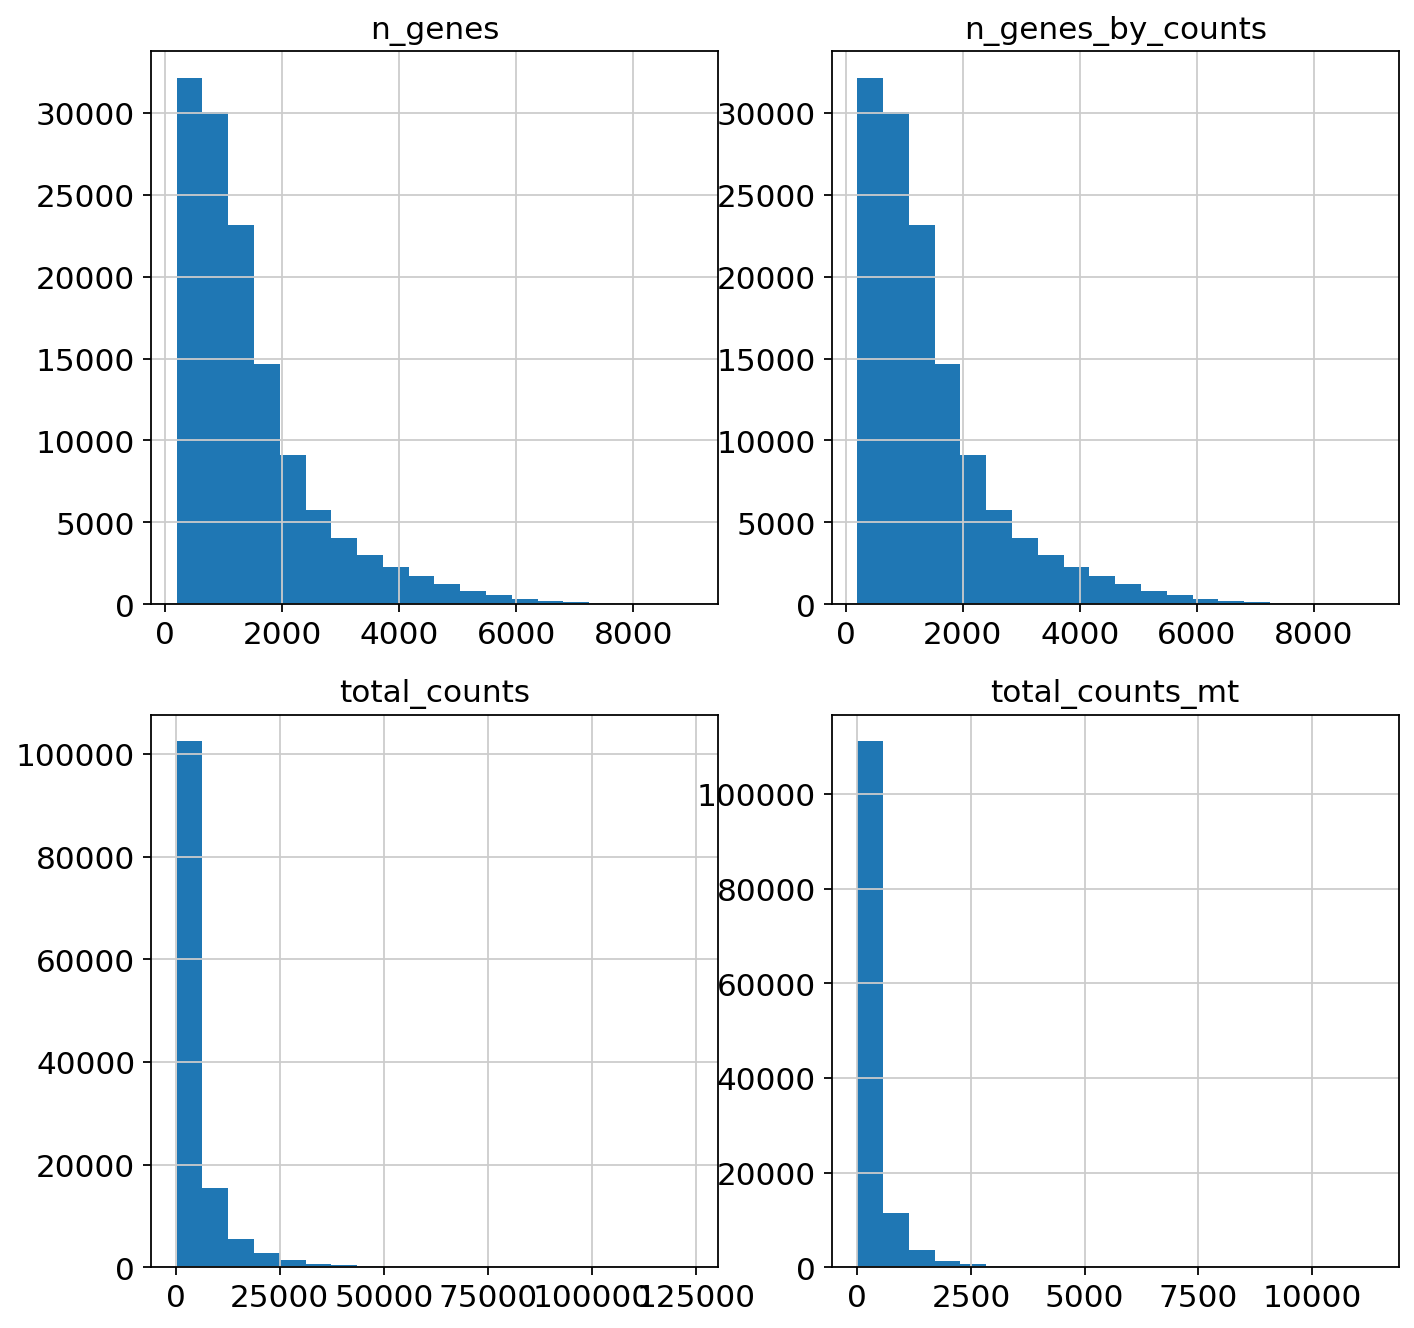

In [19]:
qc_obs = [
    "n_genes",
    "n_genes_by_counts",
    "total_counts",
    "total_counts_mt",
    "pct_counts_mt",
]
nrows_i = 2
ncols_i = 2
i = 0
fig, axs = plt.subplots(nrows=nrows_i, ncols=ncols_i)
for j in range(nrows_i):
    for k in range(ncols_i):
        if (len(qc_obs) - 1) >= i:
            axs[j, k].hist(adata_obs[qc_obs[i]], bins=20)
            axs[j, k].set_title(qc_obs[i])
            i += 1

### Remove doublets [if the info present] <a class="anchor" id="bullet5"></a>

del adata.uns
del adata.obsm
del adata.varm
del adata.obsp
adata### Make object lightweight <a class="anchor" id="bullet6"></a>
Remove uns, varm, obsm, obsp, layers, and reduce obs columns if duplicated stuff or unlabelled clustering outputs exist.

In [20]:
del adata.uns
del adata.obsm
del adata.varm
del adata.obsp
adata

AnnData object with n_obs × n_vars = 129340 × 20922
    obs: 'institute', 'study_PI', 'sample_ID', 'subject_ID', 'library_ID', 'subject_ID_published', 'subject_developmental_state', 'age_years', 'sex', 'ethnicity_1', 'smoking_status', 'smoking_history', 'bmi', 'disease_lung_known', 'subject_type', 'cause_of_death', 'sample_type', 'anatomical_region_level1', 'anatomical_region_level3', 'protocol_tissue_dissociation', 'biological_unit', 'library_platform', 'strand_sequence', 'cell_enrichment', 'sequencing_platform', 'reference_genome', 'reference_genome_ensembl_release', 'reads_processing', 'sample_collection_year', 'disease_status', 'treatment_status', 'sample_status', 'sample_cultured', 'cell_number_loaded', 'cell_viability_percentage', 'comments', 'study', 'dataset', 'sample', 'disease_condition', 'original_celltype_ann'
    var: 'mt', 'gene_ids-0', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'gene_ids-1', 'n_cells-1', 'n_cells_by_

### Check if you need to split them into datasets <a class="anchor" id="bullet7"></a>
If different protocols were used, e.g., 10X versions, or if there were single-nuclei data or cryopreserved samples.

In [21]:
pd.crosstab(adata.obs.library_platform, adata.obs.study)

study,Meyer_2021
library_platform,
10x_3'_v2,24628
10x_5'_v1,104712


In [22]:
pd.crosstab(adata.obs.library_platform, adata.obs.dataset)

dataset,Meyer_2021_3prime,Meyer_2021_5prime
library_platform,,
10x_3'_v2,24628,0
10x_5'_v1,0,104712


#### Write down everything you did in the "preprocessing" column <a class="anchor" id="bullet8"></a>
Sheet: [Dataset overview](https://docs.google.com/spreadsheets/d/1V_dAIApfDG9Q1lsJGRePzDIosjn--ei-r7PKi9WWBsw/edit#gid=0&range=Q1).

### Subset to HVGs <a class="anchor" id="bullet8"></a>
Pad with 0s if needed.

In [23]:
adata.var

,mt,gene_ids-0,n_cells-0,n_cells_by_counts-0,mean_counts-0,pct_dropout_by_counts-0,total_counts-0,gene_ids-1,n_cells-1,n_cells_by_counts-1,...,pct_dropout_by_counts-1,total_counts-1,feature_types-1,n_cells,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
FAM87B,False,FAM87B,176,176,0.001221,99.879938,178.966705,ENSG00000177757,39,39,...,99.966985,37.157669,Gene Expression,196,False,0.001895,1.718146,-0.593497,0,False
LINC00115,False,LINC00115,2468,2468,0.017432,98.316404,2555.424072,ENSG00000225880,911,911,...,99.228803,851.700073,Gene Expression,2926,False,0.034289,1.777689,-0.360488,0,False
FAM41C,False,FAM41C,955,955,0.006955,99.348528,1019.574158,ENSG00000230368,175,175,...,99.851856,165.668961,Gene Expression,986,False,0.010345,1.972112,-0.150652,1,False
SAMD11,False,SAMD11,1750,1750,0.019036,98.806202,2790.467041,ENSG00000187634,1109,1109,...,99.061188,1118.028442,Gene Expression,2284,False,0.035187,1.811885,-0.101987,0,False
NOC2L,False,NOC2L,17570,17570,0.147330,88.014271,21597.226562,ENSG00000188976,5334,5334,...,95.484559,5078.837891,Gene Expression,19626,False,0.212764,1.889519,-0.077502,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC023491.2,False,AC023491.2,35,35,0.000266,99.976124,38.998932,ENSG00000278633,27,27,...,99.977143,26.716158,Gene Expression,40,False,0.000331,1.519368,-0.584777,0,False
AC004556.1,False,AC004556.1,2975,2975,0.025639,97.970544,3758.375000,ENSG00000276345,354,354,...,99.700325,266.433228,Gene Expression,2949,False,0.040713,2.134076,0.372613,1,False
AC233755.2,False,AC233755.2,104,104,0.064795,99.929054,9498.426758,ENSG00000277856,10,10,...,99.991535,24.979130,Gene Expression,90,False,0.021040,4.567000,4.135742,1,False
AC233755.1,False,AC233755.1,127,127,0.135452,99.913364,19856.105469,ENSG00000275063,12,12,...,99.989842,12.580947,Gene Expression,113,False,0.029828,4.531441,3.646755,1,False


In [24]:
genes_set = pd.read_csv(genes_set_inp)
genes_set

,Unnamed: 0,gene_symbols
0,ENSG00000000938,FGR
1,ENSG00000000971,CFH
2,ENSG00000002587,HS3ST1
3,ENSG00000002933,TMEM176A
4,ENSG00000003436,TFPI
...,...,...
1995,ENSG00000280721,AC133644.2
1996,ENSG00000281103,TRG-AS1
1997,ENSG00000282122,CH17-262H11.1
1998,ENSG00000282988,RP1-34B20.21


In [25]:
adata_sub = pp.subset_and_pad_adata(genes_set, adata)

not all genes were recovered, filling in 0 counts for 93 missing genes...


In [26]:
adata_sub.var

,mt,gene_ids-0,n_cells-0,n_cells_by_counts-0,mean_counts-0,pct_dropout_by_counts-0,total_counts-0,gene_ids-1,n_cells-1,n_cells_by_counts-1,...,feature_types-1,n_cells,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection,gene_symbols,ensembl
FGR,False,FGR,29176.0,29176.0,0.403429,80.097005,59139.015625,ENSG00000000938,5465.0,5465.0,...,Gene Expression,30305.0,False,0.426606,2.281436,0.661877,1.0,False,NaN,ENSG00000000938
CFH,False,CFH,16584.0,16584.0,0.322872,88.686891,47330.167969,ENSG00000000971,19864.0,19864.0,...,Gene Expression,28775.0,True,0.853707,3.170846,1.891768,2.0,True,NaN,ENSG00000000971
HS3ST1,False,HS3ST1,8978.0,8978.0,0.179070,93.875477,26250.078125,ENSG00000002587,2933.0,2933.0,...,Gene Expression,10423.0,False,0.161305,2.105936,0.364874,1.0,False,NaN,ENSG00000002587
TMEM176A,False,TMEM176A,11845.0,11845.0,0.245946,91.919695,36053.398438,ENSG00000002933,438.0,438.0,...,Gene Expression,11610.0,False,0.182475,2.086519,0.150973,1.0,False,NaN,ENSG00000002933
TFPI,False,TFPI,31654.0,31654.0,1.078160,78.406587,158048.531250,ENSG00000003436,35374.0,35374.0,...,Gene Expression,50253.0,True,1.313589,2.981305,0.703852,2.0,True,NaN,ENSG00000003436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RP11-356I2.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RP11-356I2.4,ENSG00000237499
RP11-620J15.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RP11-620J15.3,ENSG00000257698
CTB-61M7.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CTB-61M7.2,ENSG00000268734
RP11-501J20.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RP11-501J20.5,ENSG00000225936


In [27]:
vars_keep = ["gene_ids-0", "gene_symbols", "ensembl"]
for i in list(set(adata_sub.var.columns) - set(vars_keep)):
    del adata_sub.var[i]

In [28]:
adata_sub

AnnData object with n_obs × n_vars = 129340 × 2000
    obs: 'institute', 'study_PI', 'sample_ID', 'subject_ID', 'library_ID', 'subject_ID_published', 'subject_developmental_state', 'age_years', 'sex', 'ethnicity_1', 'smoking_status', 'smoking_history', 'bmi', 'disease_lung_known', 'subject_type', 'cause_of_death', 'sample_type', 'anatomical_region_level1', 'anatomical_region_level3', 'protocol_tissue_dissociation', 'biological_unit', 'library_platform', 'strand_sequence', 'cell_enrichment', 'sequencing_platform', 'reference_genome', 'reference_genome_ensembl_release', 'reads_processing', 'sample_collection_year', 'disease_status', 'treatment_status', 'sample_status', 'sample_cultured', 'cell_number_loaded', 'cell_viability_percentage', 'comments', 'study', 'dataset', 'sample', 'disease_condition', 'original_celltype_ann'
    var: 'gene_ids-0', 'gene_symbols', 'ensembl'

### Store the data <a class="anchor" id="bullet10"></a>

In [29]:
adata.write(adata_dir_out + "/full/meyer_2021.h5ad")
adata_sub.write(adata_dir_out + "/subsetted/meyer_2021.h5ad")

... storing 'institute' as categorical
... storing 'study_PI' as categorical
... storing 'sample_ID' as categorical
... storing 'subject_ID' as categorical
... storing 'library_ID' as categorical
... storing 'subject_ID_published' as categorical
... storing 'subject_developmental_state' as categorical
... storing 'sex' as categorical
... storing 'ethnicity_1' as categorical
... storing 'smoking_status' as categorical
... storing 'disease_lung_known' as categorical
... storing 'subject_type' as categorical
... storing 'cause_of_death' as categorical
... storing 'sample_type' as categorical
... storing 'anatomical_region_level1' as categorical
... storing 'anatomical_region_level3' as categorical
... storing 'protocol_tissue_dissociation' as categorical
... storing 'biological_unit' as categorical
... storing 'library_platform' as categorical
... storing 'strand_sequence' as categorical
... storing 'cell_enrichment' as categorical
... storing 'sequencing_platform' as categorical
... stor

#### Update the stats for your dataset <a class="anchor" id="bullet11"></a>
Sheet: [Dataset overview](https://docs.google.com/spreadsheets/d/1V_dAIApfDG9Q1lsJGRePzDIosjn--ei-r7PKi9WWBsw/edit#gid=0)